In [83]:
# import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from time import time
import pprint
import joblib
from functools import partial
from skopt.utils import use_named_args # decorator to convert a list of parameters to named arguments
from skopt import gp_minimize, forest_minimize
from skopt import gbrt_minimize, dummy_minimize
# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Classifiers
from xgboost import XGBRegressor

# Model selection
from sklearn.model_selection import KFold

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer
# to increase no. of rows and column visibility in outputs
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.width', 2000)

[16:00:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "boosting_type", "metric", "min_child_samples", "num_leaves", "subsample_freq", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:01:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "boosting_type", "metric", "min_child_samples", "num_leaves", "subsample_freq", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly her

In [2]:
#Import data
train = pd.read_csv(r'data/Train.csv')
test = pd.read_csv(r'data/Test.csv')

 **Basic Visulization**

In [3]:
# Having a look at data and its shape 
train.head()
test.head()
train.shape ,test.shape 

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE
0,Owner,0,0,1,BHK,545.171340,1,1,"Kamrej,Surat",21.262000,73.047700
1,Dealer,1,1,2,BHK,800.000000,0,0,"Panvel,Lalitpur",18.966114,73.148278
2,Dealer,0,0,2,BHK,1257.096513,1,1,"New Town,Kolkata",22.592200,88.484911
3,Dealer,0,0,3,BHK,1400.329489,1,1,"Kalwar Road,Jaipur",26.988300,75.584600
4,Owner,0,0,1,BHK,430.477830,1,1,"Mai Mandir,Nadiad",22.700000,72.870000


((29451, 12), (68720, 11))

### Summarizing the number of unique values in each column


In [4]:
print(train.nunique())
print(test.nunique())

POSTED_BY                    3
UNDER_CONSTRUCTION           2
RERA                         2
BHK_NO.                     16
BHK_OR_RK                    2
SQUARE_FT                19561
READY_TO_MOVE                2
RESALE                       2
ADDRESS                   6899
LONGITUDE                 4087
LATITUDE                  4078
TARGET(PRICE_IN_LACS)     1172
dtype: int64
POSTED_BY                 3
UNDER_CONSTRUCTION        2
RERA                      2
BHK_NO.                  17
BHK_OR_RK                 2
SQUARE_FT             37704
READY_TO_MOVE             2
RESALE                    2
ADDRESS               11048
LONGITUDE              5907
LATITUDE               5914
dtype: int64


### Columns with  single value

Columns that have a single value are probably useless for modeling. These
columns are referred to zero-variance predictors, so we dont need to use them anymore.

In [5]:
values = train.nunique()
single_value_cols = [values.index[i] for i,v in enumerate(values) if v == 1]
single_value_cols

[]

In [6]:
train.drop(single_value_cols, axis=1, inplace=True)

### Checking duplicate rows

Duplicate row is a row where each value in each column for that row appears in identically the same column values in another row.  They are could be useless to the modeling process. 

duplicated() function will report whether a given row is duplicated or not. All
rows are marked as either False to indicate that it is not a duplicate or True to indicate that
it is a duplicate.

In [7]:
dups = train.duplicated()
print(dups.any())

True


In [8]:
train = train.drop_duplicates(keep = 'first')
train

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5
...,...,...,...,...,...,...,...,...,...,...,...,...
29446,Owner,0,0,3,BHK,2500.000000,1,1,"Shamshabad Road,Agra",27.140626,78.043277,45.0
29447,Owner,0,0,2,BHK,769.230769,1,1,"E3-108, Lake View Recidency,,Vapi",39.945409,-86.150721,16.0
29448,Dealer,0,0,2,BHK,1022.641509,1,1,"Ajmer Road,Jaipur",26.928785,75.828002,27.1
29449,Owner,0,0,2,BHK,927.079009,1,1,"Sholinganallur,Chennai",12.900150,80.227910,67.0


In [9]:
test = test.drop_duplicates(keep = 'first')

In [10]:
# to check type of columns and identify whether missing values exist or not
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29050 entries, 0 to 29450
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   POSTED_BY              29050 non-null  object 
 1   UNDER_CONSTRUCTION     29050 non-null  int64  
 2   RERA                   29050 non-null  int64  
 3   BHK_NO.                29050 non-null  int64  
 4   BHK_OR_RK              29050 non-null  object 
 5   SQUARE_FT              29050 non-null  float64
 6   READY_TO_MOVE          29050 non-null  int64  
 7   RESALE                 29050 non-null  int64  
 8   ADDRESS                29050 non-null  object 
 9   LONGITUDE              29050 non-null  float64
 10  LATITUDE               29050 non-null  float64
 11  TARGET(PRICE_IN_LACS)  29050 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 2.9+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 66250 entries, 0 to 68719
Data columns (total 11 co

In [11]:
train.columns

Index(['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK', 'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'ADDRESS', 'LONGITUDE', 'LATITUDE', 'TARGET(PRICE_IN_LACS)'], dtype='object')

In [12]:
#Conerting categorical variable to numeric
train['BHK_OR_RK']=train['BHK_OR_RK'].replace({'BHK':0,'RK':1})
train['POSTED_BY']=train['POSTED_BY'].replace({'Owner':0,'Dealer':1,'Builder':2})

test['BHK_OR_RK']=test['BHK_OR_RK'].replace({'BHK':0,'RK':1})
test['POSTED_BY']=test['POSTED_BY'].replace({'Owner':0,'Dealer':1,'Builder':2})

<AxesSubplot:title={'center':'Price Distribution'}, ylabel='Density'>

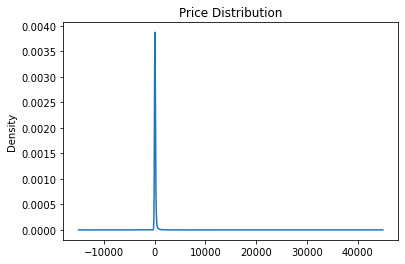

In [13]:
# found out that there is no. missing value and only one address as object type variable
# Target varibale distribution 
train['TARGET(PRICE_IN_LACS)'].plot(kind = 'density', title = 'Price Distribution')

In [14]:
train['TARGET_log']=np.log1p(train['TARGET(PRICE_IN_LACS)'])

<AxesSubplot:title={'center':'log of Price Distribution'}, ylabel='Density'>

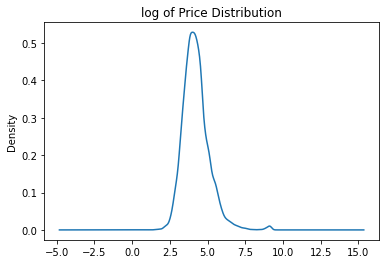

In [15]:
# Transforming target varible(log transformation), because target is to optimize Root mean square log error
# and checking log transformed varibale distribution
train['TARGET_log'].plot(kind = 'density', title = 'log of Price Distribution')

In [16]:
del train['TARGET(PRICE_IN_LACS)']

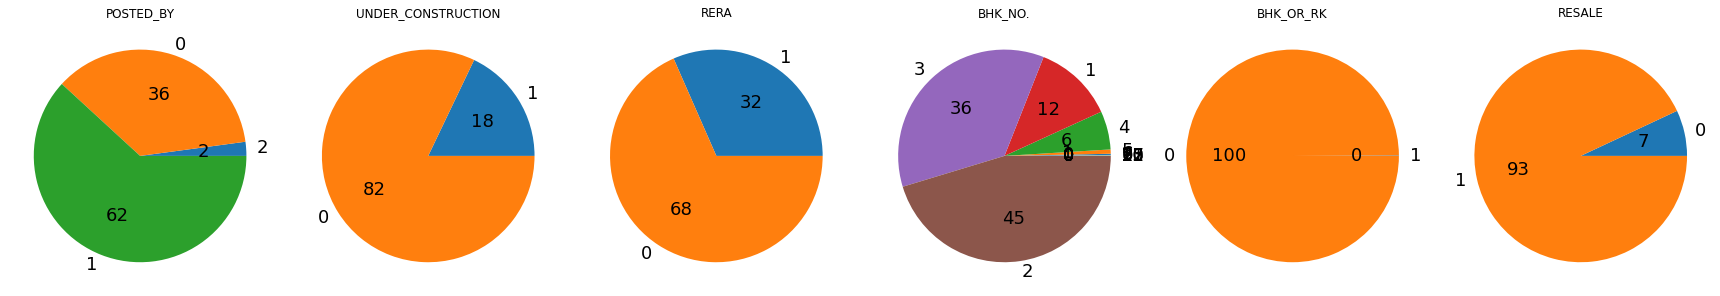

In [17]:
# Analysing distribution in Categorical varibales 
cat_cols = ['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK', 'RESALE']
fig, axes = plt.subplots(1,6, figsize=(24, 10))

for i, c in enumerate(['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK', 'RESALE']):
    _ = train[c].value_counts()[::-1].plot(kind = 'pie', ax=axes[i], title=c, autopct='%.0f', fontsize=18)
    _ = axes[i].set_ylabel('')
    
_ = plt.tight_layout()

<Figure size 864x360 with 0 Axes>

Text(0.5, 1.0, 'Distribution of UNDER_CONSTRUCTION')

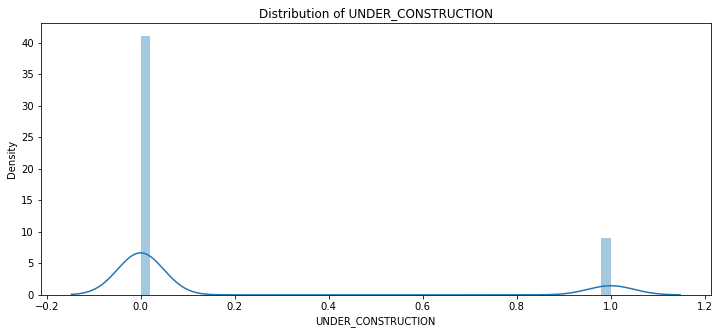

<Figure size 864x360 with 0 Axes>

Text(0.5, 1.0, 'Distribution of RERA')

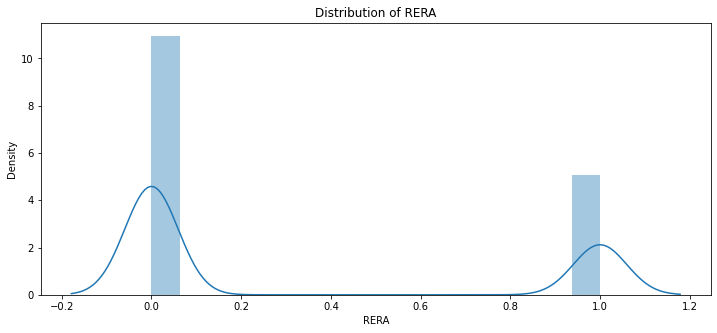

<Figure size 864x360 with 0 Axes>

Text(0.5, 1.0, 'Distribution of BHK_NO.')

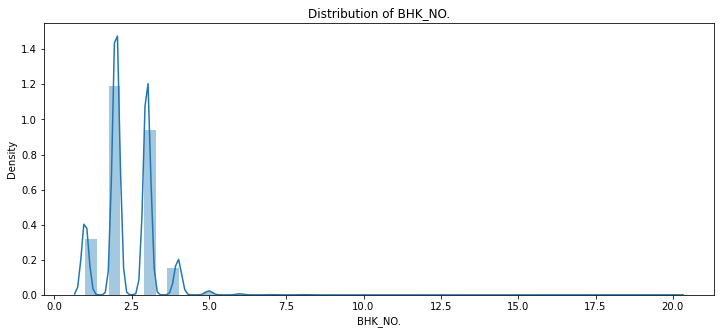

<Figure size 864x360 with 0 Axes>

Text(0.5, 1.0, 'Distribution of BHK_OR_RK')

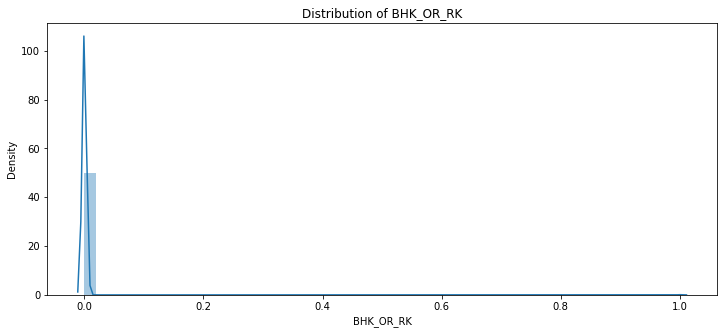

<Figure size 864x360 with 0 Axes>

Text(0.5, 1.0, 'Distribution of SQUARE_FT')

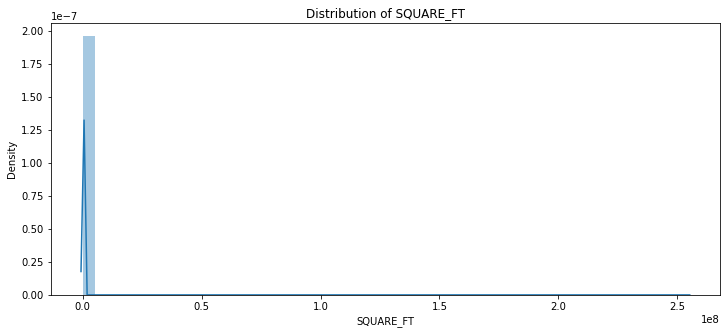

<Figure size 864x360 with 0 Axes>

Text(0.5, 1.0, 'Distribution of READY_TO_MOVE')

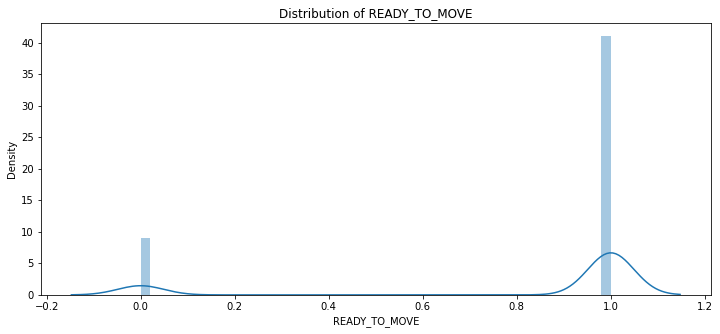

<Figure size 864x360 with 0 Axes>

Text(0.5, 1.0, 'Distribution of RESALE')

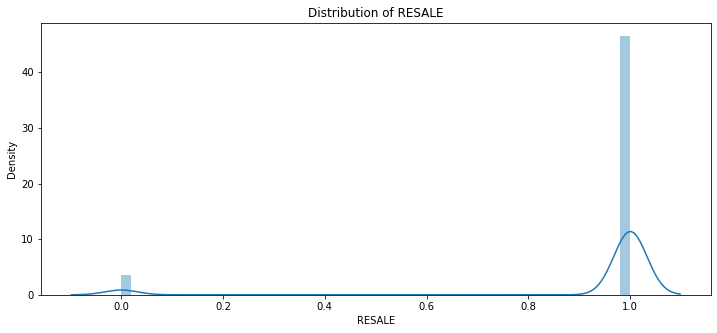

<Figure size 864x360 with 0 Axes>

Text(0.5, 1.0, 'Distribution of LONGITUDE')

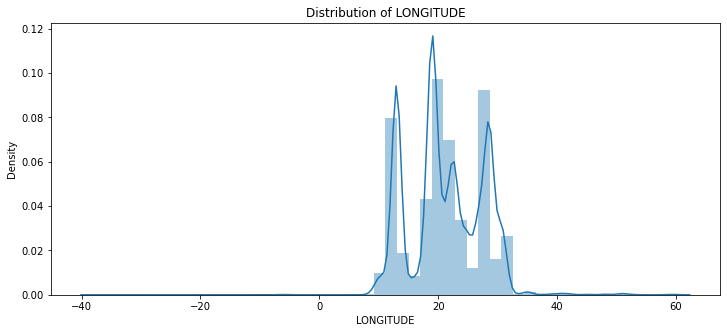

<Figure size 864x360 with 0 Axes>

Text(0.5, 1.0, 'Distribution of LATITUDE')

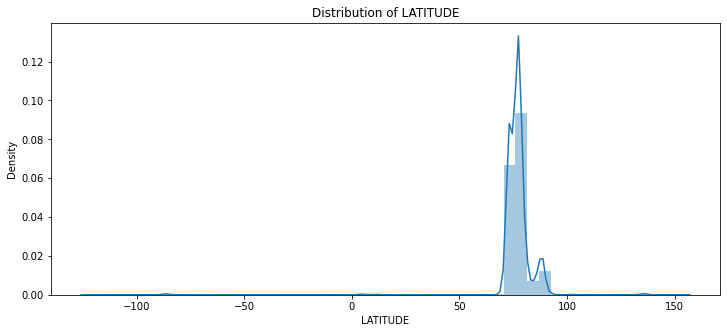

<Figure size 864x360 with 0 Axes>

Text(0.5, 1.0, 'Distribution of TARGET_log')

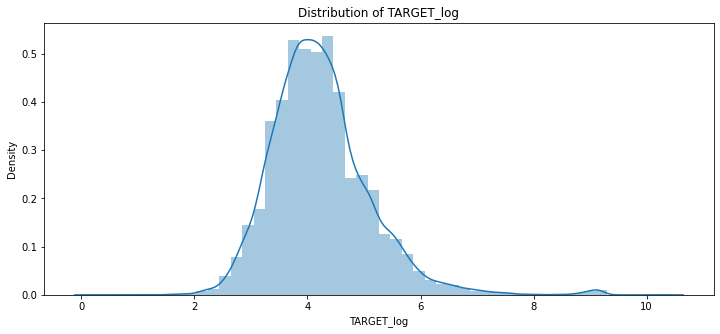

In [83]:
numeric = train.select_dtypes(include = 'number')
for col in list(numeric)[1:]:
    plt.figure(figsize=(12,5))
    plt.title(f"Distribution of {col}")
    ax = sns.distplot(train[col])
    plt.show()

<Figure size 1080x576 with 0 Axes>

<AxesSubplot:>

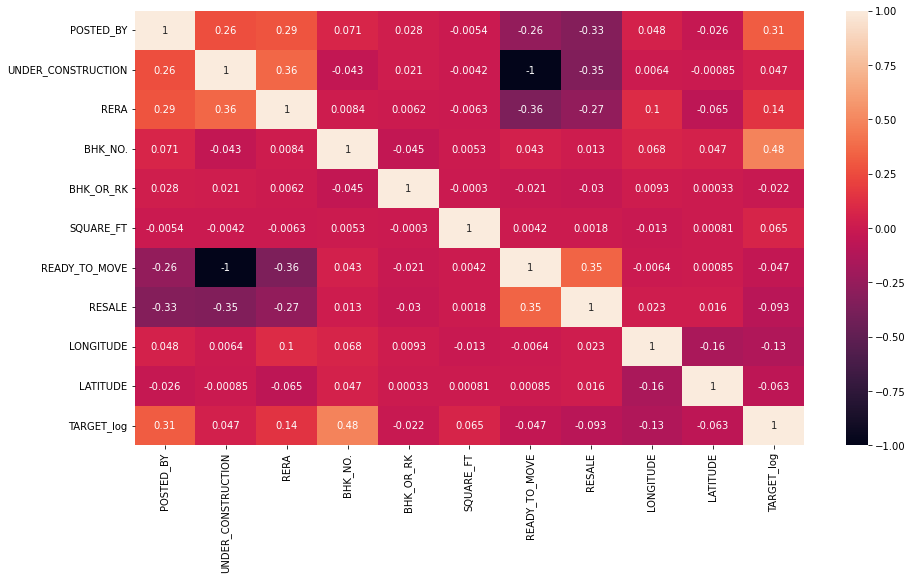

In [18]:
# Checking correlation
plt.figure(figsize=(15, 8))
sns.heatmap(train.corr(),annot=True)

# Feature Engineering

In [19]:
train['sq_per_room']=train['SQUARE_FT']/train['BHK_NO.']
test['sq_per_room']=test['SQUARE_FT']/test['BHK_NO.']

In [20]:
# Extracting name of city and locality of house
train['City']=train['ADDRESS'].str.split(',').str.get(-1)
train['locality']=train['ADDRESS'].str.split(',').str.get(-2)

test['City']=test['ADDRESS'].str.split(',').str.get(-1)
test['locality']=test['ADDRESS'].str.split(',').str.get(-2)

In [21]:
train

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET_log,sq_per_room,City,locality
0,0,0,0,2,0,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,4.025352,650.118204,Bangalore,Ksfc Layout
1,1,0,0,2,0,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,3.951244,637.500000,Mysore,Vishweshwara Nagar
2,0,0,0,2,0,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,3.784190,466.579861,Bangalore,Jigani
3,0,0,1,2,0,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,4.151040,464.960571,Ghaziabad,Sector-1 Vaishali
4,1,1,0,2,0,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,4.119037,499.504623,Kolkata,New Town
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29446,0,0,0,3,0,2500.000000,1,1,"Shamshabad Road,Agra",27.140626,78.043277,3.828641,833.333333,Agra,Shamshabad Road
29447,0,0,0,2,0,769.230769,1,1,"E3-108, Lake View Recidency,,Vapi",39.945409,-86.150721,2.833213,384.615385,Vapi,
29448,1,0,0,2,0,1022.641509,1,1,"Ajmer Road,Jaipur",26.928785,75.828002,3.335770,511.320755,Jaipur,Ajmer Road
29449,0,0,0,2,0,927.079009,1,1,"Sholinganallur,Chennai",12.900150,80.227910,4.219508,463.539505,Chennai,Sholinganallur


In [22]:
train.drop(['ADDRESS','LONGITUDE','LATITUDE','locality'], axis = 1, inplace = True)
test.drop(['ADDRESS','LONGITUDE','LATITUDE','locality'], axis = 1, inplace = True)

In [23]:
train.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,TARGET_log,sq_per_room,City
0,0,0,0,2,0,1300.236407,1,1,4.025352,650.118204,Bangalore
1,1,0,0,2,0,1275.000000,1,1,3.951244,637.500000,Mysore
2,0,0,0,2,0,933.159722,1,1,3.784190,466.579861,Bangalore
3,0,0,1,2,0,929.921143,1,1,4.151040,464.960571,Ghaziabad
4,1,1,0,2,0,999.009247,0,1,4.119037,499.504623,Kolkata


In [24]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncode(BaseEstimator, TransformerMixin):
    
    def __init__(self, categories='auto', k=1, f=1, 
                 noise_level=0, random_state=None):
        if type(categories)==str and categories!='auto':
            self.categories = [categories]
        else:
            self.categories = categories
        self.k = k
        self.f = f
        self.noise_level = noise_level
        self.encodings = dict()
        self.prior = None
        self.random_state = random_state
        
    def add_noise(self, series, noise_level):
        return series * (1 + noise_level *   
                         np.random.randn(len(series)))
        
    def fit(self, X, y=None):
        if type(self.categories)=='auto':
            self.categories = np.where(X.dtypes == type(object()))[0]
        
        temp = X.loc[:, self.categories].copy()
        temp['target'] = y
        self.prior = np.mean(y)
        for variable in self.categories:
            avg = (temp.groupby(by=variable)['target']
                       .agg(['mean', 'count']))
            # Compute smoothing 
            smoothing = (1 / (1 + np.exp(-(avg['count'] - self.k) /                 
                         self.f)))
            # The bigger the count the less full_avg is accounted
            self.encodings[variable] = dict(self.prior * (1 -  
                             smoothing) + avg['mean'] * smoothing)
            
        return self
    
    def transform(self, X):
        Xt = X.copy()
        for variable in self.categories:
            Xt[variable].replace(self.encodings[variable], 
                                 inplace=True)
            unknown_value = {value:self.prior for value in 
                             X[variable].unique() 
                             if value not in 
                             self.encodings[variable].keys()}
            if len(unknown_value) > 0:
                Xt[variable].replace(unknown_value, inplace=True)
            Xt[variable] = Xt[variable].astype(float)
            if self.noise_level > 0:
                if self.random_state is not None:
                    np.random.seed(self.random_state)
                Xt[variable] = self.add_noise(Xt[variable], 
                                              self.noise_level)
        return Xt
    
    def fit_transform(self, X, y=None):
        
        self.fit(X, y)
        return self.transform(X)

# Target encoding

In [25]:
te = TargetEncode(categories='City')
te.fit(train, train['TARGET_log'])
train['City'] = te.transform(train[['City']])
test['City'] = te.transform(test[['City']])

TargetEncode(categories=['City'])

# Train test split

In [26]:
X_train = train.drop(["TARGET_log"],axis=1)
y_train = train.loc[:,'TARGET_log']

X_test = test.copy()

In [27]:
print(f'X train shape is: {X_train.shape}')
print(f'X test shape is: {X_test.shape}')
print(f'y train shape is: {y_train.shape}')

X train shape is: (29050, 10)
X test shape is: (66250, 10)
y train shape is: (29050,)


# Outlier removing

In [29]:
def pre_quantiles(df, column, q1 = 0.25, q3 = 0.75):
    """
    This function takes dataframe, each column separetly and calculates the
    percentiles of a dataset. The IQR can then be calculated as the difference between
    the 75th and 25th percentiles
    """
    Q1 = df[column].quantile(q1)
    Q3 = df[column].quantile(q3)
    IQR = Q3-Q1
    return Q1, Q3, IQR

def remove_outliers_numerical(df, column, Q1, Q3, IQR, coeff):
    """
    This function takes dataframe, each column, their 1st and 3rd quantiles, interquartile ranges and coefficiants.
    Then calculate the cutoff for outliers as 0.5 times the IQR and subtract this cut-off
    from the 25th percentile and add it to the 75th percentile to give the actual limits on the data. As a result of
    function we get dataframe which have each column's mentioned numbers.
    
    """
    
    df_o = df[~(((df[column] < (Q1 - coeff * IQR)[column])) | ((df[column] > (Q3 + coeff * IQR)[column])))]
    
    return df_o

def remove_from_dataframe(df, name):
    """
    This function takes dataframe and selects numerical variables and will remove outliers from them.
    Although, it is accepted that if our dependent variable is binary, then we won't get any outliers. I will not
    exclude them due to code complexity.
    
    """
    del_col = df.select_dtypes(exclude = 'number').columns
    numerical_columns = df.columns.difference(del_col)
    print(f'Before removing {name} outliers: {df.shape}')

    Q_data = pd.DataFrame(pre_quantiles(df, numerical_columns, q1 = 0.005, q3 = 0.995), index=['Q1', 'Q3', 'IQR'])

    for i in numerical_columns:
        df = remove_outliers_numerical(df, i, Q_data.iloc[0]["{0}".format(i)],
                                                      Q_data.iloc[1]["{0}".format(i)], Q_data.iloc[-1], coeff = 0.5)

    print(f'After removing {name} outliers: {df.shape}\n')
    return df



In [30]:
X_train_outlier_free = remove_from_dataframe(X_train, 'TRAIN')
X_test_outlier_free = remove_from_dataframe(X_test, 'TEST')


y_train = pd.DataFrame(y_train)
y_train = y_train.loc[y_train.index & X_train_outlier_free.index]

Before removing TRAIN outliers: (29050, 10)
After removing TRAIN outliers: (28850, 10)

Before removing TEST outliers: (66250, 10)
After removing TEST outliers: (65816, 10)




# Modeling


In [53]:
lm = LinearRegression()
scores = cross_val_score(lm, X_train_outlier_free, y_train, scoring='r2', cv=5)
scores.mean()

0.6689547495944086

# Bayesian optimization using scikit-optimization



**Bayesian Optimization** (*SNOEK, Jasper; LAROCHELLE, Hugo; ADAMS, Ryan P. Practical bayesian optimization of machine learning algorithms. In: Advances in neural information processing systems. 2012. p. 2951-2959*)

The key idea behind Bayesian optimization is that we optimize a proxy function (the surrogate function) instead than the true objective function (what actually grid search and random search both do). This holds if testing the true objective function is costly (if it is not, then we simply go for random search.

Bayesian search balances exploration against exploitation. At start it randomly explores, doing so it builds up a surrogate function of the objective. Based on that surrogate function it exploits an initial approximate knowledge of how the predictor works in order to sample more useful examples and minimize the cost function at a global level, not a local one.

Bayesian Optimization uses an acquisition function to tell us how promising an observation will be. In fact, to rule the tradeoff between exploration and exploitation, the algorithm defines an acquisition function that provides a single measure of how useful it would be to try any given point.

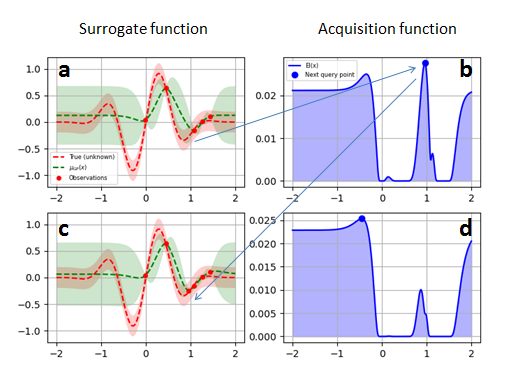

In this step by ste tutorial, we will deal Bayesian optimization using LightGBM in few clear steps:

2. Define our cross-validation strategy
3. Define our evaluation metric
4. Define our base model
5. Define our hyper-parameter search space
6. Run optimization for a while

# Setting up optimization

First, we create a wrapper function to deal with running the optimizer and reporting back its best results.

In [54]:
def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performance of optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    
    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

We then define the evaluation metric, using the Scikit-learn function make_scorer allows us to convert the optimization into a minimization problem, as required by Scikit-optimize. We set squared=False by means of a partial function to obtain the root mean squared error (RMSE) as evaluation.

In [55]:
# Setting the scoring function
scoring = make_scorer(partial(mean_squared_error, squared=False), 
                      greater_is_better=False)

We set up a  5-fold cross validation

In [56]:
# Setting the validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=0)

We set up a generic LightGBM regressor.

In [66]:
# Setting the basic regressor
reg = XGBRegressor(boosting_type='gbdt',
                        metric='rmse',
                        n_jobs=1, 
                        verbose=-1,
                        random_state=0)

We define a search space, expliciting the key hyper-parameters to optimize and the range where to look for the best values.


In [67]:
# Setting the search space
space = {
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),     # Boosting learning rate
    'n_estimators': Integer(30, 5000),                   # Number of boosted trees to fit
    'num_leaves': Integer(2, 512),                       # Maximum tree leaves for base learners
    'max_depth': Integer(-1, 256),                       # Maximum tree depth for base learners, <=0 means no limit
    'min_child_samples': Integer(1, 256),                # Minimal number of data in one leaf
    'max_bin': Integer(100, 1000),                       # Max number of bins that feature values will be bucketed
    'subsample': Real(0.01, 1.0, 'uniform'),             # Subsample ratio of the training instance
    'subsample_freq': Integer(0, 10),                    # Frequency of subsample, <=0 means no enable
    'colsample_bytree': Real(0.01, 1.0, 'uniform'),      # Subsample ratio of columns when constructing each tree
    'min_child_weight': Real(0.01, 10.0, 'uniform'),     # Minimum sum of instance weight (hessian) needed in a child (leaf)
    'reg_lambda': Real(1e-9, 100.0, 'log-uniform'),      # L2 regularization
    'reg_alpha': Real(1e-9, 100.0, 'log-uniform'),       # L1 regularization
   }

We then define the Bayesian optimization engine, providing to it our LightGBM, the search spaces, the evaluation metric, the cross-validation. We set a large number of possible experiments and some parallelism in the search operations.

In [68]:
# Wrapping everything up into the Bayesian optimizer
opt = BayesSearchCV(estimator=reg,                                    
                    search_spaces=space,                      
                    scoring=scoring,                                  
                    cv=kf,                                           
                    n_iter=60,                                        # max number of trials
                    n_points=3,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=-1,                                        # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=0)                                   # random state for replicability

Finally we runt the optimizer and wait for the results. We have set some limits to its operations: we required it to stop if it cannot get consistent improvements from the search (DeltaYStopper) and time dealine set in seconds (we decided for 6 hours).

In [70]:
# Running the optimizer
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60) # We impose a time limit (6 hours)

best_params = report_perf(opt, X_train_outlier_free, y_train,'XGBoost_regression', 
                          callbacks=[overdone_control, time_limit_control])

[16:01:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "boosting_type", "metric", "min_child_samples", "num_leaves", "subsample_freq", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:01:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "boosting_type", "metric", "min_child_samples", "num_leaves", "subsample_freq", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly her

In [71]:
best_params

OrderedDict([('colsample_bytree', 0.2995039650878967),
             ('learning_rate', 0.2755314693466253),
             ('max_bin', 348),
             ('max_depth', 77),
             ('min_child_samples', 247),
             ('min_child_weight', 5.535702996085901),
             ('n_estimators', 2249),
             ('num_leaves', 256),
             ('reg_alpha', 20.66725678679388),
             ('reg_lambda', 1.2801597911124966e-08),
             ('subsample', 0.5850817422118535),
             ('subsample_freq', 2)])

# Prediction on test data

Having got the best hyperparameters for the data at hand, we instantiate a lightGBM using such values and train our model on all the available examples.

After having trained the model, we predict on the test set and we save the results on a csv file.

In [72]:
# Transferring the best parameters to our basic regressor
reg = XGBRegressor(boosting_type='gbdt',
                        metric='rmse',
                        n_jobs=1, 
                        verbose=-1,
                        random_state=0,
                         **best_params)

In [73]:
# Fitting the regressor on all the data
scores = cross_val_score(reg, X_train_outlier_free, y_train, scoring='r2', cv=5)
scores.mean()

[16:03:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "boosting_type", "metric", "min_child_samples", "num_leaves", "subsample_freq", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:04:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "boosting_type", "metric", "min_child_samples", "num_leaves", "subsample_freq", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly her

0.7924200505118185

# Customizing Bayesian optimization

The BayesSearchCV function offered by Scikit-optimize is certainly convenient, because it wraps and arranges all the elements of a hyperparameter search by itself, but it also has limitations.

Each of these tasks would not be too complex if you could modify the BayesSearchCV internal procedure. Luckily, Scikit-optimize lets you do just this. In fact, behind BayesSearchCV, as well as behind other wrappers from the package, there are specific minimizing functions that you can use as standalone parts of your own search function:

gp_minimize: Bayesian optimization using Gaussian processes forest_minimize: Bayesian optimization using random forests or
extremely randomized trees

gbrt_minimize: Bayesian optimization using gradient boosting 

dummy_minimize: Just random search


In the following example, we are going to modify the previous search using our own custom search function. The new custom function will accept early stopping during training and it will prune experiments if one of the fold validation results is not a top- performing one.

In [151]:
# Setting the search space
space = [Real(0.01, 1.0, 'uniform', name='learning_rate'),
         Integer(1, 8, name='max_depth'),
         Real(0.1, 1.0, 'uniform', name='subsample'),
         Real(0.1, 1.0, 'uniform', name='colsample_bytree'),  # subsample ratio of columns by tree
         Real(0, 100., 'uniform', name='reg_lambda'),      # L2 regularization
         Real(0, 100., 'uniform', name='reg_alpha'),       # L1 regularization
         Real(1, 30, 'uniform', name='min_child_weight'),     # minimum sum of instance weight (hessian)
]
scoring = partial(mean_squared_error, squared=False)

In [152]:
model = XGBRegressor(n_estimators=10_000, 
                     booster='gbtree', random_state=0)

As a next step, you now need to create the objective function. The objective function should just accept as input the parameters to be optimized and return the resulting score.

In [153]:
# The objective function to be minimized
def make_objective(model, X, y, space, cv, scoring, validation=0.2):
    # This decorator converts your objective function with named arguments into one that
    # accepts a list as argument, while doing the conversion automatically.
    
    @use_named_args(space) 
    def objective(**params):
        model.set_params(**params)
        print("\nTesting: ", params)
        validation_scores = list()
        for k, (train_index, test_index) in enumerate(kf.split(X, y)):
            val_index = list()
            train_examples = len(train_index)
            train_examples = int(train_examples * (1 - validation))
            train_index, val_index = train_index[:train_examples], train_index[train_examples:]
            start_time = time()
            model.fit(X.iloc[train_index,:], y[train_index],
                      early_stopping_rounds=50,
                      eval_set=[(X.iloc[val_index,:], y[val_index])], 
                      verbose=0
                    )
            end_time = time()
            
            rounds = model.best_iteration
            
            test_preds = model.predict(X.iloc[test_index,:])
            print(len(test_preds), len(y[test_index]))
            test_score = scoring(y[test_index], test_preds)
            print(f"CV Fold {k+1} rmse:{test_score:0.5f} - {rounds} rounds - it took {end_time-start_time:0.0f} secs")
            validation_scores.append(test_score)
            
            if len(history[k]) >= 10:
                threshold = np.percentile(history[k], q=25)
                if test_score > threshold:
                    print(f"Early stopping for under-performing fold: threshold is {threshold:0.5f}")
                    return np.mean(validation_scores)
                
            history[k].append(test_score)
        return np.mean(validation_scores)

    return objective

In [154]:
X_train_outlier_free.reset_index(drop = True,inplace = True)

In [155]:
y_train[:10]

0    4.025352
1    3.951244
2    3.784190
3    4.151040
4    4.119037
5    3.761200
6    4.212128
7    3.970292
8    3.751854
9    3.610918
Name: TARGET_log, dtype: float64

In [156]:
objective = make_objective(model,
                           X_train_outlier_free, y_train,
                           space=space,
                           cv=kf,
                           scoring=scoring)

In [157]:
def onstep(res):
    global counter
    x0 = res.x_iters   # List of input points
    y0 = res.func_vals # Evaluation of input points
    print('Last eval: ', x0[-1], 
          ' - Score ', y0[-1])
    print('Current iter: ', counter, 
          ' - Best Score ', res.fun, 
          ' - Best Args: ', res.x)
    joblib.dump((x0, y0), 'checkpoint.pkl') # Saving a checkpoint to disk
    counter += 1

In [158]:
counter = 0
history = {i:list() for i in range(5)}
used_time = 0

In [159]:
gp_round = dummy_minimize(func=objective,
                          dimensions=space,
                          n_calls=30,
                          callback=[onstep],
                          random_state=0)


Testing:  {'learning_rate': 0.5969161720427683, 'max_depth': 1, 'subsample': 0.6424870384644795, 'colsample_bytree': 0.5903948646972073, 'reg_lambda': 42.36547993389048, 'reg_alpha': 64.58941130666562, 'min_child_weight': 13.690029126618084}
5770 5770
CV Fold 1 rmse:0.41188 - 4524 rounds - it took 9 secs
5770 5770
CV Fold 2 rmse:0.42608 - 1556 rounds - it took 3 secs
5770 5770
CV Fold 3 rmse:0.41000 - 2636 rounds - it took 5 secs
5770 5770
CV Fold 4 rmse:0.40062 - 4218 rounds - it took 8 secs
5770 5770
CV Fold 5 rmse:0.39983 - 3405 rounds - it took 6 secs
Last eval:  [0.5969161720427683, 1, 0.6424870384644795, 0.5903948646972073, 42.36547993389048, 64.58941130666562, 13.690029126618084]  - Score  0.4096813225128565
Current iter:  0  - Best Score  0.4096813225128565  - Best Args:  [0.5969161720427683, 1, 0.6424870384644795, 0.5903948646972073, 42.36547993389048, 64.58941130666562, 13.690029126618084]

Testing:  {'learning_rate': 0.8928552707742591, 'max_depth': 1, 'subsample': 0.345390

5770 5770
CV Fold 1 rmse:0.39898 - 1667 rounds - it took 4 secs
5770 5770
CV Fold 2 rmse:0.41184 - 1897 rounds - it took 4 secs
5770 5770
CV Fold 3 rmse:0.39936 - 1284 rounds - it took 3 secs
5770 5770
CV Fold 4 rmse:0.39210 - 1084 rounds - it took 623 secs
5770 5770
CV Fold 5 rmse:0.38817 - 1589 rounds - it took 4 secs
Last eval:  [0.25198133608158674, 8, 0.4042068533550026, 0.7072770900331187, 31.720174206929613, 77.83454820259091, 28.537560550071525]  - Score  0.3980912527711372
Current iter:  9  - Best Score  0.3689277661452418  - Best Args:  [0.21827873546310253, 4, 0.7756175270966107, 0.6470476018439211, 32.504722900835255, 3.842542647273473, 19.393947680762718]

Testing:  {'learning_rate': 0.6659015982805438, 'max_depth': 7, 'subsample': 0.18739114821375516, 'colsample_bytree': 0.8541504167489236, 'reg_lambda': 9.609840789396308, 'reg_alpha': 97.6459465013396, 'min_child_weight': 14.590884847783347}
5770 5770
CV Fold 1 rmse:0.46100 - 243 rounds - it took 0 secs
Early stopping fo

5770 5770
CV Fold 1 rmse:0.42960 - 1185 rounds - it took 2 secs
Early stopping for under-performing fold: threshold is 0.38360
Last eval:  [0.7516781387811975, 1, 0.22192665780020523, 0.3684540933604278, 56.996491070126496, 59.08727612481733, 17.655432216637788]  - Score  0.42959603208815206
Current iter:  20  - Best Score  0.3689277661452418  - Best Args:  [0.21827873546310253, 4, 0.7756175270966107, 0.6470476018439211, 32.504722900835255, 3.842542647273473, 19.393947680762718]

Testing:  {'learning_rate': 0.6566688116585624, 'max_depth': 6, 'subsample': 0.38889751723614785, 'colsample_bytree': 0.2991364166654045, 'reg_lambda': 14.126390492589671, 'reg_alpha': 9.72599270631739, 'min_child_weight': 29.537224999560248}
5770 5770
CV Fold 1 rmse:0.38169 - 296 rounds - it took 1 secs
5770 5770
CV Fold 2 rmse:0.38638 - 490 rounds - it took 1 secs
5770 5770
CV Fold 3 rmse:0.37723 - 357 rounds - it took 1 secs
5770 5770
CV Fold 4 rmse:0.37131 - 454 rounds - it took 932 secs
5770 5770
CV Fold 

In [160]:
x0, y0 = joblib.load('checkpoint.pkl')
print(len(x0))

30


In [161]:
x0, y0 = joblib.load('checkpoint.pkl')

gp_round = gp_minimize(func=objective,
                       x0=x0,              # already examined values for x
                       y0=y0,              # observed values for x0
                       dimensions=space,
                       acq_func='gp_hedge',
                       n_calls=30,
                       n_initial_points=0,
                       callback=[onstep],
                       random_state=0)

Last eval:  [0.3188255455248059, 6, 0.29115144900127776, 0.3001989019481369, 21.874937373677188, 56.95735345747381, 14.111162015969347]  - Score  0.39962672396435683
Current iter:  30  - Best Score  0.3689277661452418  - Best Args:  [0.21827873546310253, 4, 0.7756175270966107, 0.6470476018439211, 32.504722900835255, 3.842542647273473, 19.393947680762718]

Testing:  {'learning_rate': 0.01, 'max_depth': 8, 'subsample': 0.6020826274165189, 'colsample_bytree': 1.0, 'reg_lambda': 0.0, 'reg_alpha': 2.486596047168666, 'min_child_weight': 1.0}
5770 5770
CV Fold 1 rmse:0.36396 - 1353 rounds - it took 14 secs
5770 5770
CV Fold 2 rmse:0.37603 - 1282 rounds - it took 13 secs
5770 5770
CV Fold 3 rmse:0.36792 - 1674 rounds - it took 18 secs
5770 5770
CV Fold 4 rmse:0.36220 - 1141 rounds - it took 11 secs
5770 5770
CV Fold 5 rmse:0.36466 - 1225 rounds - it took 12 secs
Last eval:  [0.01, 8, 0.6020826274165189, 1.0, 0.0, 2.486596047168666, 1.0]  - Score  0.3669540207930301
Current iter:  31  - Best Sc

Last eval:  [0.01, 7, 0.6446179747880219, 0.6295480680234297, 0.0, 0.0, 1.0]  - Score  0.3636095527254331
Current iter:  42  - Best Score  0.3636095527254331  - Best Args:  [0.01, 7, 0.6446179747880219, 0.6295480680234297, 0.0, 0.0, 1.0]

Testing:  {'learning_rate': 0.01, 'max_depth': 8, 'subsample': 1.0, 'colsample_bytree': 1.0, 'reg_lambda': 0.0, 'reg_alpha': 49.26398740687431, 'min_child_weight': 12.698802401114014}
5770 5770
CV Fold 1 rmse:0.38256 - 1501 rounds - it took 12 secs
Early stopping for under-performing fold: threshold is 0.36844
Last eval:  [0.01, 8, 1.0, 1.0, 0.0, 49.26398740687431, 12.698802401114014]  - Score  0.3825638110696024
Current iter:  43  - Best Score  0.3636095527254331  - Best Args:  [0.01, 7, 0.6446179747880219, 0.6295480680234297, 0.0, 0.0, 1.0]

Testing:  {'learning_rate': 0.01, 'max_depth': 6, 'subsample': 0.46139963106276005, 'colsample_bytree': 0.6821604309284095, 'reg_lambda': 0.0, 'reg_alpha': 0.0, 'min_child_weight': 1.0}
5770 5770
CV Fold 1 rmse:

Last eval:  [0.01, 4, 0.5811961295678728, 0.6838801460634866, 0.0, 0.0, 1.0]  - Score  0.3734551896982372
Current iter:  56  - Best Score  0.3636095527254331  - Best Args:  [0.01, 7, 0.6446179747880219, 0.6295480680234297, 0.0, 0.0, 1.0]

Testing:  {'learning_rate': 0.9336793132767992, 'max_depth': 2, 'subsample': 0.9745242739174469, 'colsample_bytree': 0.24513669924007395, 'reg_lambda': 65.53605064390061, 'reg_alpha': 2.659571289612751, 'min_child_weight': 20.795462360241054}
5770 5770
CV Fold 1 rmse:0.37896 - 766 rounds - it took 2 secs
Early stopping for under-performing fold: threshold is 0.36747
Last eval:  [0.9336793132767992, 2, 0.9745242739174469, 0.24513669924007395, 65.53605064390061, 2.659571289612751, 20.795462360241054]  - Score  0.3789638261593534
Current iter:  57  - Best Score  0.3636095527254331  - Best Args:  [0.01, 7, 0.6446179747880219, 0.6295480680234297, 0.0, 0.0, 1.0]

Testing:  {'learning_rate': 0.9691519808734451, 'max_depth': 3, 'subsample': 0.5779015331749207

In [162]:
x0, y0 = joblib.load('checkpoint.pkl')
print(len(x0))

60


In [163]:
print(f"Best score: {gp_round.fun:0.5f}")
print("Best hyperparameters:")
for sp, x in zip(gp_round.space, gp_round.x):
    print(f"{sp.name:25} : {x}")

Best score: 0.36361
Best hyperparameters:
learning_rate             : 0.01
max_depth                 : 7
subsample                 : 0.6446179747880219
colsample_bytree          : 0.6295480680234297
reg_lambda                : 0.0
reg_alpha                 : 0.0
min_child_weight          : 1.0


# Conclusion

Now we have the set of parameters and their results (the x0 and y0 lists), we could also explore the different results and cluster together the ones that are similar in output but different in the set of parameters used. This will help us to train a more diverse set of models with similar performances but different optimization strategies.